In [60]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp
import os
import urllib.request as urlreq
import skimage
from skimage.transform import PiecewiseAffineTransform, warp
import json
import sklearn

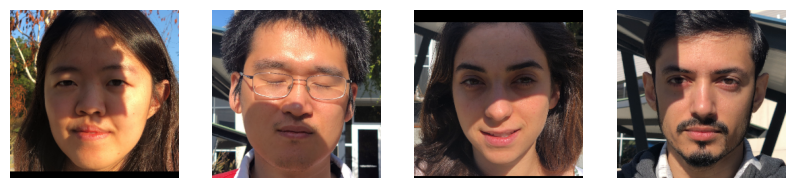

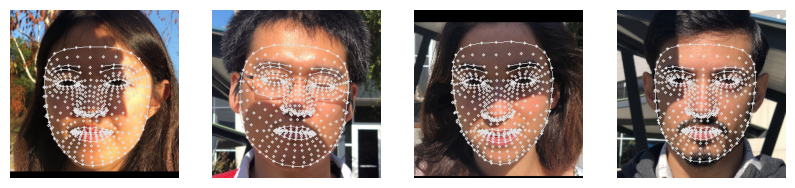

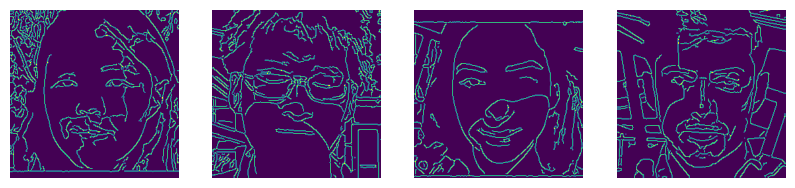

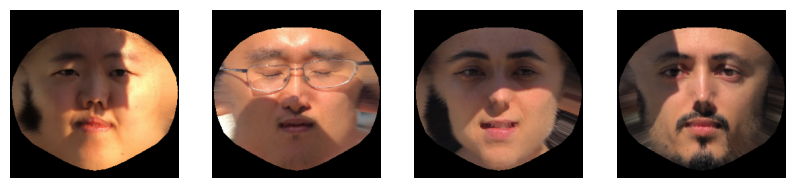

In [49]:
validation_paths = [
    "images/9156-004.png",
    "images/9162-031.png",
    "images/9165-009.png",
    "images/9169-020.png"
]
images = [(plt.imread(path) * 255).astype(np.uint8) for path in validation_paths]

uv_path = "uv_map.json" #taken from https://github.com/spite/FaceMeshFaceGeometry/blob/353ee557bec1c8b55a5e46daf785b57df819812c/js/geometry.js
uv_map_dict = json.load(open(uv_path))
uv_map = np.array([ (uv_map_dict["u"][str(i)],uv_map_dict["v"][str(i)]) for i in range(468)])

def display_images(images):
    # display images as a row of subfigures
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(images[i])
        plt.axis('off')

def detect_face(image):
    # save face detection algorithm's url in haarcascade_url variable
    haarcascade_url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt2.xml"
    # save face detection algorithm's name as haarcascade
    haarcascade = "haarcascade_frontalface_alt2.xml"
    # chech if file is in working directory
    if not (haarcascade in os.listdir(os.curdir)):
        urlreq.urlretrieve(haarcascade_url, haarcascade)
    # create an instance of the Face Detection Cascade Classifier
    detector = cv2.CascadeClassifier(haarcascade)

    # Detect faces using the haarcascade classifier on the "grayscale image"
    faces = detector.detectMultiScale(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    if len(faces) > 0:
        return faces[0]
    else:
        return np.array([0, image.shape[1], 0, image.shape[0]])

def display_bounding_boxes(images, bounding_boxes):
    image_templates = [image.copy() for image in images]
    for i, bounding_box in enumerate(bounding_boxes):
        (x,y,w,d) = bounding_box
        cv2.rectangle(image_templates[i],(x,y),(x+w, y+d),(255, 255, 255), 2)
    display_images(image_templates)

def detect_landmarks(image, bounding_box):
    # save facial landmark detection model's url in LBFmodel_url variable
    LBFmodel_url = "https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml"
    # save facial landmark detection model's name as LBFmodel
    LBFmodel = "LFBmodel.yaml"
    # check if file is in working directory
    if not (LBFmodel in os.listdir(os.curdir)):
        urlreq.urlretrieve(LBFmodel_url, LBFmodel)
    # create an instance of the Facial landmark Detector with the model
    landmark_detector  = cv2.face.createFacemarkLBF()
    landmark_detector.loadModel(LBFmodel)
    # Detect landmarks on "image_gray"
    _, landmarks = landmark_detector.fit(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), np.array([bounding_box]))
    if len(landmarks) > 0:
        return landmarks[0]
    else:
        return np.zeros((68, 2))

def display_landmarks(images, landmarks):
    image_templates = [image.copy() for image in images]
    for i, landmark_set in enumerate(landmarks):
        for landmark in landmark_set[0]:
            x, y = landmark
            cv2.circle(image_templates[i], (int(x), int(y)), 1, (255, 255, 255), 2)
    display_images(image_templates)

def detect_landmarks_3D(image):
    NUM_FACE = 1
    mpFaceMesh = mp.solutions.face_mesh
    faceMesh = mpFaceMesh.FaceMesh(max_num_faces=NUM_FACE)
    imgRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = faceMesh.process(imgRGB)
    if results.multi_face_landmarks:
        return results.multi_face_landmarks[0]
    else:
        return None
    
def display_landmarks_3D(images, landmarkss):
    img_templates = [image.copy() for image in images]
    for i, landmarks in enumerate(landmarkss):
        mpDraw = mp.solutions.drawing_utils
        drawSpec = mpDraw.DrawingSpec(thickness=1, circle_radius=1)
        img = img_templates[i]
        mpFaceMesh = mp.solutions.face_mesh
        mpDraw.draw_landmarks(img, landmarks, mpFaceMesh.FACEMESH_CONTOURS, drawSpec, drawSpec)
        for id,lm in enumerate(landmarks.landmark):
            ih, iw, ic = img.shape
            x,y = int(lm.x*iw), int(lm.y*ih)
    display_images(img_templates)

def detect_edges(image):
    # blur the image
    blurred_image = cv2.GaussianBlur(image, (7, 7), 0)
    # apply canny edge detection algorithm on the image
    return cv2.Canny(blurred_image, 25, 100)

def unwrap_face(image, landmarks):
    H_new,W_new = image.shape[0],image.shape[1]
    keypoints_uv = np.array([(W_new*x, H_new*y) for x,y in uv_map])
    keypoints = np.array([(W_new*point.x,H_new*point.y) for point in landmarks.landmark[0:468]])

    tform = PiecewiseAffineTransform()
    tform.estimate(keypoints_uv, keypoints)
    texture = warp(image, tform, output_shape=(H_new,W_new))
    texture = (255*texture).astype(np.uint8)

    return texture
        


display_images(images)
landmarks_3D = [detect_landmarks_3D(image) for image in images]
display_landmarks_3D(images, landmarks_3D)
edges = [detect_edges(image) for image in images]
display_images(edges)
unwrapped_faces = [unwrap_face(image, landmarks) for image, landmarks in zip(images, landmarks_3D)]
display_images(unwrapped_faces)

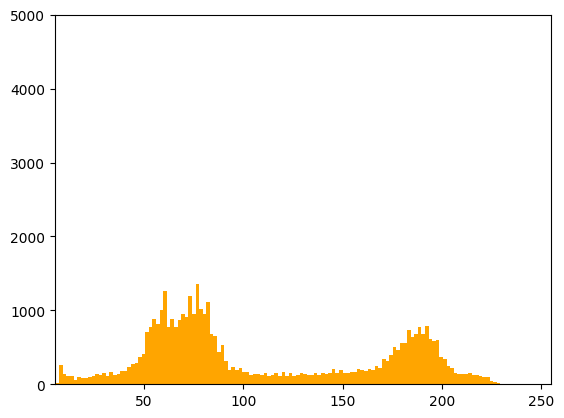

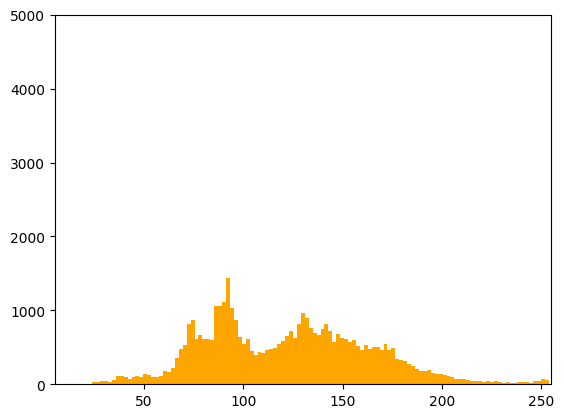

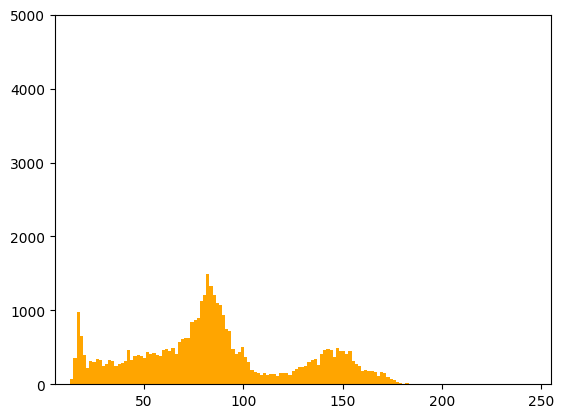

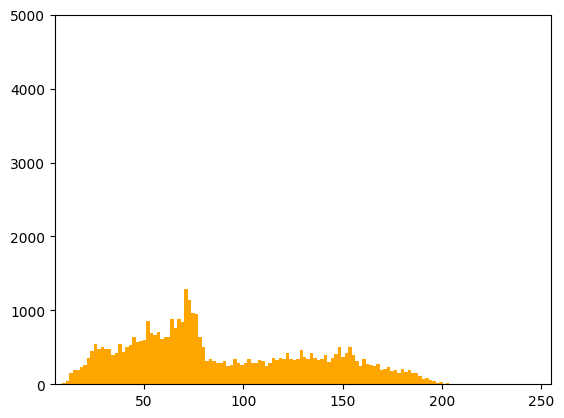

In [69]:
for face in unwrapped_faces:
    f = np.sum(face, axis = 2) / 3
    plt.hist(f.flatten(), bins = 128, color = 'orange')
    plt.xlim([5,255])
    plt.ylim([0,5000])
    plt.show()

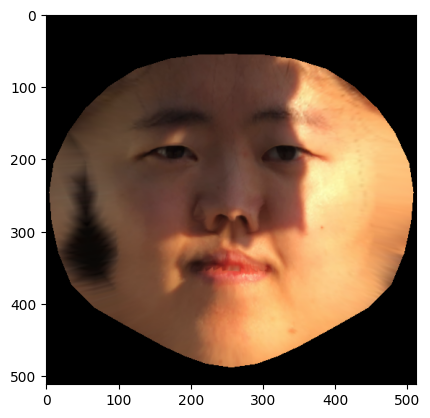

In [45]:


uv_path = "uv_map.json" #taken from https://github.com/spite/FaceMeshFaceGeometry/blob/353ee557bec1c8b55a5e46daf785b57df819812c/js/geometry.js
uv_map_dict = json.load(open(uv_path))
uv_map = np.array([ (uv_map_dict["u"][str(i)],uv_map_dict["v"][str(i)]) for i in range(468)])


H_new,W_new = 512,512
keypoints_uv = np.array([(W_new*x, H_new*y) for x,y in uv_map])
keypoints = np.array([(images[0].shape[1]*point.x,images[0].shape[0]*point.y) for point in landmarks_3D[0].landmark[0:468]])

tform = PiecewiseAffineTransform()
tform.estimate(keypoints_uv, keypoints)
texture = warp(images[0], tform, output_shape=(H_new,W_new))
texture = (255*texture).astype(np.uint8)

ax = plt.imshow(texture)
plt.show()